<a href="https://colab.research.google.com/github/d1p013/testing/blob/master/Assignment_Simple_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTerrier Indexing Demo

This notebook takes you through indexing using [PyTerrier](https://github.com/terrier-org/pyterrier).

## Prerequisites

You will need PyTerrier installed. PyTerrier also needs Java to be installed, and will find most installations.

In [61]:
!pip install python-terrier
#!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git#egg=python-terrier

## Init 

You must run `pt.init()` before other pyterrier functions and classes

Optional Arguments:    
 - `version` - terrier IR version e.g. "5.2"    
 - `mem` - megabytes allocated to java e.g. "4096"      
 - `packages` - external java packages for Terrier to load e.g. ["org.terrier:terrier.prf"]
 - `logging` - logging level for Terrier. Defaults to "WARN", use "INFO" or "DEBUG" for more output.

NB: PyTerrier needs Java 11 installed. If it cannot find your Java installation, you can set the `JAVA_HOME` environment variable.

In [62]:
import pyterrier as pt
if not pt.started():
  pt.init()

 ## Importing dataset from Google Drive

Using built-in function of Google Colab, we can easily import the dataset which has been uploaded onto Google Drive beforehand

need a Google account to download the data

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID which is residing on Google Drive
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# file_id = '1YkltHAl3Ro9xv25EkGB56h271_STNlPA' #'AI6122_Dataset_B1.csv'
file_id = '1aVXMJ_luTXISxMwP5_Bt2xE0ObXqEsQ2' #"Dataset_B1to8"

downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
#downloaded.GetContentFile('AI6122_Dataset_B1.csv')
downloaded.GetContentFile('Dataset_B1to8.csv')

## Loading dataset (csv) into Pandas dataframe

pyTerrier makes it easy to index standard Python data structures, particularly [Pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

importing dataset, which is scale down version of the original `review.json` file as the original file is too large to load into Google Colab memory


In [79]:
## load data into df
import pandas as pd
#df = pd.read_csv("AI6122_Dataset_B1.csv", dtype = str)
df = pd.read_csv("Dataset_B1to8.csv", dtype = str)

try :
  del docno 
except:
  pass

docno =[]
for idx in range(1,len(df)+1):
  docno.append("d" + str(idx))

df["docno"] = docno


## Time taken for indexing

Tracking the time to complete indexing for each 10% incremental of documents. The index folder is cleared before each indexing and time and is taken before and after indexing, the difference being the time taken to index


In [5]:
import time

Tcollect = []
for idx in range(1,11):
  #print(idx)
  df_resize = df.iloc[:int(len(df)/(10/idx)),:]
  !rm -rf ./pd_index
  pd_indexer = pt.DFIndexer("./pd_index", overwrite=True, verbose=True)
  Tstart = time.perf_counter()
  indexref = pd_indexer.index(df_resize["text"], df_resize)
  Tend = time.perf_counter()
  print(str(10*idx)+f"% df search completed in {Tend - Tstart:0.4f} seconds")
  Tcollect.append(Tend - Tstart)



  0%|          | 0/692 [00:00<?, ?documents/s]

10% df search completed in 3.5966 seconds


  0%|          | 0/1385 [00:00<?, ?documents/s]

20% df search completed in 3.1806 seconds


  0%|          | 0/2078 [00:00<?, ?documents/s]

30% df search completed in 4.0451 seconds


  0%|          | 0/2771 [00:00<?, ?documents/s]

40% df search completed in 3.8554 seconds


  0%|          | 0/3464 [00:00<?, ?documents/s]

50% df search completed in 4.6979 seconds


  0%|          | 0/4156 [00:00<?, ?documents/s]

60% df search completed in 5.3065 seconds


  0%|          | 0/4849 [00:00<?, ?documents/s]

70% df search completed in 6.1361 seconds


  0%|          | 0/5542 [00:00<?, ?documents/s]

80% df search completed in 6.6730 seconds


  0%|          | 0/6235 [00:00<?, ?documents/s]

90% df search completed in 7.4599 seconds


  0%|          | 0/6928 [00:00<?, ?documents/s]

100% df search completed in 8.2375 seconds


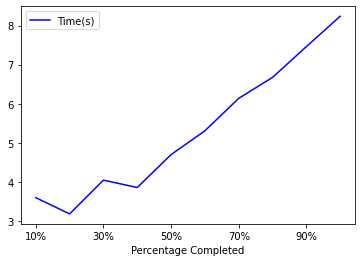

In [6]:
import matplotlib.pyplot as plt

plotdf = pd.DataFrame({
    'Percentage Completed':['10%', '20%', '30%', '40%', '50%', 
                            '60%', '70%', '80%', '90%', '100%'],
    'Time(s)':Tcollect
    })

# a scatter plot comparing num_children and num_pets
plotdf.plot(kind='line',x='Percentage Completed',y='Time(s)',color='blue')
plt.show()


## Indexing a Pandas dataframe

We can use a `pt.DFIndexer()` object to do indexing for Pandas dataframe

In [80]:
#import pandas as pd
!rm -rf ./pd_index
pd_indexer = pt.DFIndexer("./pd_index", overwrite=True, verbose=True)

# optionally modify properties
# index_properies = {"block.indexing":"true", "invertedfile.lexiconscanner":"pointers"}
# indexer.setProperties(**index_properies)

pd_indexer.setProperty("termpipelines", "Stopwords,PorterStemmer")
# no stemming or stopwords
#pd_indexer.setProperty("termpipelines", "")

Then there are a number of options to index the dataframe:    
The first argument should always a pandas.Series object of Strings, which specifies the body of each document.    
Any arguments after that are for specifying metadata.

We can view more useful information from the indexed objects using a indexref.getCollectionsStatistics()

In [81]:
import time

# Add metadata fields as Pandas.Series objects, with the name of the Series object becoming the name of the meta field.
#indexref = pd_indexer.index(df["text"], df["docno"], df["review_id"], df["user_id"], df["business_id"], df["stars"], df["useful"], df["funny"], df["cool"])
Tstart = time.perf_counter()
# Add the entire dataframe as metadata
indexref = pd_indexer.index(df["text"], df)
Tend = time.perf_counter()
print(f"search completed in {Tend - Tstart:0.4f} seconds")
indexinfo = pt.IndexFactory.of(indexref)
print(indexinfo.getCollectionStatistics().toString()) 

  0%|          | 0/6928 [00:00<?, ?documents/s]

search completed in 8.4887 seconds
Number of documents: 6928
Number of terms: 12049
Number of postings: 323743
Number of fields: 0
Number of tokens: 388543
Field names: []
Positions:   false



In the above example, the indexed collection had 6928 documents, which contained 388543-word occurrences. Out of which 12049 were identified as unique words. The total postings in the inverted index are 323743. 

The whole datafame is being index, with the `"text"` field being searchable while the remaining (e.g. `"review_id"`, `"user_id"`, `"business_id"`, `"stars"`, `"date"`, `"useful"`, `"funny"`, `"cool"`, `"text"`) as metadata which can be displayed when called upon.

pyTerrier perform standard stopwords removal and applies Porter's stemmer by default, and it is applicable in this notebook as well.
EnglishTokeniser is the default tokeniser and case-folding to lower case is applied during Tokenization

## Retrieval

Retrieval takes place using the `BatchRetrieve` object, by invoking `transform()` method for one or more queries. For a quick test, you can give just pass your query to `transform()`. 

BatchRetrieve will return the results as a Pandas dataframe.


In [83]:
#pt.BatchRetrieve(indexref).search("he")

,docid,docno,rank,score,qid,query


In [10]:

#this ranker will make the candidate set of documents for each query
#BM25 = pt.BatchRetrieve(indexref, controls = {"wmodel": "BM25"}, num_results=5)
#these rankers we will use to re-rank the BM25 results
#TF_IDF = pt.BatchRetrieve(indexref, controls = {"wmodel": "TF_IDF"}, num_results=5)
#PL2 =  pt.BatchRetrieve(indexref, controls = {"wmodel": "PL2"}, num_results=5)

#pipe = BM25 >> (TF_IDF ** PL2)
#pipe.transform("really cute restaurant") 


In [11]:
#pt.BatchRetrieve(indexref, controls = {"wmodel": "PL2"}, num_results=5).search("Really cute restaurant")


In [12]:
#pt.BatchRetrieve(indexref, wmodel="BM25", properties={"termpipelines" : "Stopwords,PorterStemmer"})
#pt.BatchRetrieve(indexref, controls = {"wmodel": "BM25"}, properties={"termpipelines" : ""}, num_results=10).search("Really cute restaurant")
#pt.BatchRetrieve(indexref, metadata=["business_id", "stars"], num_results=10).search("Really cute restaurant")


However, most IR experiments, will use a set of queries. You can pass such a set using a data frame for input.

In [13]:
#import pandas as pd
#topics = pd.DataFrame([["q1", "Really cute restaurant"], ["q2", "restaurant"]],columns=['qid','query'])
#pt.BatchRetrieve(indexref, metadata=["text"], num_results=5).transform(topics)

## Simple Search Engine

Prompting user input for search string
Prompting user input for the Top N results to return
Display the time taken to complete the search
Display the search results

#Search 1

In [86]:
import time
import pandas as pd
pd.reset_option('^display.', silent=True)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

search_str = input("Please enter your search string: ")
#print("Search string: ", search_str)
TopN = input("Please enter number results to display: ")
#print("Top N results: ", TopN)
Tstart = time.perf_counter()
topics = pd.DataFrame([["q1", search_str]],columns=['qid','query'])
results = pt.BatchRetrieve(indexref, wmodel="TF_IDF", properties={"termpipelines" : "Stopwords,PorterStemmer"}, metadata=["text"], num_results=int(TopN)).transform(topics)
Tend = time.perf_counter()
print(f"search completed in {Tend - Tstart:0.4f} seconds")

if len(results) == 0:
  print("no result found!")
#else:
  #print("len: ", len(results))
  #print(results)

results

Please enter your search string: Resaurant
Please enter number results to display: 5
search completed in 0.0295 seconds


,qid,docid,text,rank,score,query
0,q1,2241,"from begining to end this place was great, ser...",0,7.755881,Resaurant


#Search 2

In [98]:
search_str = input("Please enter your search string: ")
TopN = input("Please enter number results to display: ")
Tstart = time.perf_counter()
topics = pd.DataFrame([["q1", search_str]],columns=['qid','query'])
sdm = pt.rewrite.SequentialDependence()
results = pt.BatchRetrieve(indexref, wmodel="DPH", properties={"termpipelines" : "Stopwords,PorterStemmer"}, metadata=["text"], num_results=int(TopN)).transform(topics)
pipeline = sdm >> results
Tend = time.perf_counter()
print(f"search completed in {Tend - Tstart:0.4f} seconds")

if len(results) == 0:
  print("no result found!")

results

Please enter your search string: we have
Please enter number results to display: 3
search completed in 0.0316 seconds
no result found!


,docid,text,rank,score,qid,query


In [99]:
pipeline

ComposedPipeline(<pyterrier.rewrite.SequentialDependence object at 0x7fb99b686050>, Empty DataFrame
Columns: [docid, text, rank, score, qid, query]
Index: [])

#Search 3

In [90]:
search_str = input("Please enter your search string: ")
TopN = input("Please enter number results to display: ")
Tstart = time.perf_counter()
topics = pd.DataFrame([["q1", search_str]],columns=['qid','query'])
results = pt.BatchRetrieve(indexref, controls={"wmodel" : "TF_IDF"}, properties={"termpipelines" : "Stopwords,PorterStemmer"}, metadata=["text"], num_results=int(TopN)).transform(topics)
Tend = time.perf_counter()
print(f"search completed in {Tend - Tstart:0.4f} seconds")

if len(results) == 0:
  print("no result found!")

results

Please enter your search string: the best 3
Please enter number results to display: 5
search completed in 0.0373 seconds


,qid,docid,text,rank,score,query
0,q1,2312,I'll give it a 3 because what should have been...,0,5.244555,the best 3
1,q1,832,Best sandwich ever! Get the montecristo and th...,1,4.706645,the best 3
2,q1,6095,Best beef rib ever !Didn't want to wait 3 hour...,2,4.610600,the best 3
3,q1,3814,The best of the best. Went there on Saturday ...,3,4.606546,the best 3
4,q1,374,I'm giving them two stars because of the nice ...,4,4.344626,the best 3


gjhgjhgjhgjgjgjhgj

In [88]:
# define an example dataframe of documents
import pandas as pd
!rm -rf ./trial_index
#trial_df = pd.DataFrame({
#    'docno':
#    ['1', '2', '3'],
#    'url':
#    ['url1', 'url2', 'url3'],
#    'text':
#    ['He ran out of money, so he had to stop playing flies',
#    'He The waves were crashing on the shore; it was a',
#    'The body may perhaps compensates for the loss']
#})

import pandas as pd
trial_df = pd.read_csv("small_B1_edit.csv", dtype = str)
trial_df

# index the text, record the docnos as metadata
trial_indexer = pt.DFIndexer("./trial_index")
trial_indexer.setProperty("tokeniser" , "EnglishTokeniser")
trial_indexer.setProperty("termpipelines" , "Stopwords,PorterStemmer")

#trial_indexer.setProperty("termpipelines", "Stopwords,PorterStemmer")
trial_indexref = trial_indexer.index(trial_df["text"], trial_df["docno"])
trial_indexinfo = pt.IndexFactory.of(trial_indexref)
print(trial_indexinfo.getCollectionStatistics().toString()) 

pt.BatchRetrieve(trial_indexref, properties={"termpipelines" :"Stopwords,PorterStemmer"}, controls={"wmodel" : "TF_IDF"}).search("We")

Number of documents: 2
Number of terms: 40
Number of postings: 44
Number of fields: 0
Number of tokens: 46
Field names: []
Positions:   false



,docid,docno,rank,score,qid,query
